# Описание проекта

У нас данные стартапа, которые продает продукты питания.  

Нужно разобраться, как ведут себя пользователи мобильного приложения, а именно:  
> - сколько пользователей доходит до покупки, а сколько - остается на предыдущих шагах;  
> - на каких именно шагах отваливаются пользователи.  

Также мы проверим, как сказалось на поведение пользователей изменение шрифтов в приложении. Для этого проанализируем результаты A/A/B-теста. В нем 2 контрольные группы, с прежними шрифтами, и одна &#8212; с обновленными. 

## Ход работы

В ходе работы мы:  
1. **ознакомимся с данными**, подготовим их для анализа;  
1. **изучим данные**:  
  * сколько событий,  
  * сколько пользователей,  
  * за какой период у нас есть информация;  
1. **изучим воронку событий**:  
  * ознакомимся с событиями,  
  * как часто они происходят,  
  * как распределяются по пользователям, в каком порядке происходят;  
  * также проверим, какая доля пользователей переходит с одного шага воронки на другой, и какая доля проходит от первого события до оплаты;  
1. **проанализируем результаты эксперимента**:  
  * сравним число пользователей по группам,  
  * проверим, как соотносятся результаты теста по двум контрольным группам,  
  * сравним, как распределяется по группам количество пользователей, совершивших то или иное событие, как по контрольным, так и по тестируемой группе. 

## Описание данных


У нас есть датасет с логами из мобильного приложения. 

`EventName` — название события;  
`DeviceIDHash` — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Ознакомление с данными

In [1]:
# импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth
from datetime import datetime as dt

plt.style.use('seaborn-darkgrid')

In [2]:
logs = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
logs.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Открыли файл, видим, что в нем нет пропусков, все строки заполнены.  

В ходе предобработки нужно:  
- переименовать столбцы в "змеиный регистр", так с ними будет удобнее работать (мне), также изменить сами названия некоторых столбцов;  
- привести `EventTimestamp` к удобному для восприятия формату даты и времени, добавить новые столбцы;  
- проверить данные на дубликаты.  

# Предобработка данных

## Переименование столбцов

In [5]:
logs.columns = ['event_name', 'user_id', 'event_timestamp', 'group']

## Добавление новых столбцов с датой и временем

In [6]:
# переводим время из timestamp в привычный формат, "дата + время"

logs["date_time"] = pd.to_datetime(logs['event_timestamp'], unit="s")

In [7]:
logs["date_time"].head()

0   2019-07-25 04:43:36
1   2019-07-25 11:11:42
2   2019-07-25 11:28:47
3   2019-07-25 11:28:47
4   2019-07-25 11:48:42
Name: date_time, dtype: datetime64[ns]

In [8]:
# добавим столбец только с датами, без времени

logs["date"] = logs["date_time"].astype('datetime64[D]')

In [9]:
logs["date"].head()

0   2019-07-25
1   2019-07-25
2   2019-07-25
3   2019-07-25
4   2019-07-25
Name: date, dtype: datetime64[ns]

## Проверка на дубликаты

In [10]:
logs.head(10)

,event_name,user_id,event_timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
5,CartScreenAppear,6217807653094995999,1564055323,248,2019-07-25 11:48:43,2019-07-25
6,OffersScreenAppear,8351860793733343758,1564066242,246,2019-07-25 14:50:42,2019-07-25
7,MainScreenAppear,5682100281902512875,1564085677,246,2019-07-25 20:14:37,2019-07-25
8,MainScreenAppear,1850981295691852772,1564086702,247,2019-07-25 20:31:42,2019-07-25
9,MainScreenAppear,5407636962369102641,1564112112,246,2019-07-26 03:35:12,2019-07-26


In [11]:
logs.duplicated().sum()

413

In [12]:
'{:.1%}'.format(logs.duplicated().sum()/logs.date.count())

'0.2%'

В данных есть 413 полных дубликатов. Всего в датасете 244 тысячи строк, то есть дубликатов менее 1%. Удалим их и продолжим анализ. 

In [13]:
logs = logs.drop_duplicates()

## Проверка на пропуски в данных

In [14]:
logs.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
date_time          0
date               0
dtype: int64

Для надежности провели явную проверку на пропуски в данных. Ни в одном столбце пропущенных значений нет. 

Первоначальная подготовка данных выполнена, можно двигаться дальше. 

# Исследование данных

In [15]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   group            243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


В наших данных осталось 243.713 строк. 

Проверим, сколько у нас уникальных пользователей и сколько в среднем событий приходится на каждого пользователя.

In [16]:
# количество пользователей

logs.user_id.nunique()

7551

Проверим распределение количества событий по пользователям.  

Посчитаем среднее, медианное количество событий на пользователя, максимальное и минимальное.  

Это позволим нам выяснить, есть ли в наших данных аномалии, а также даст понять, как распределяется количество событий на пользователя, нормально или со смещением. 

Для проверки сгруппируем данные по пользователям, найдем общее количество значений по ним, и уже из этой таблицы вычислим нужные нам значения. 

In [17]:
events_by_users = (
    logs.groupby('user_id', as_index=False)
    .agg(number_events=('event_name', 'count'))
)

In [18]:
events_by_users.head()

,user_id,number_events
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


In [19]:
# Среденее количество событий
print('Среденее количество событий ', events_by_users['number_events'].mean())

# Медианное количество событий
print('Медианное количество событий ', events_by_users['number_events'].median())

# Максимально количество событий
print('Максимально количество событий ', events_by_users['number_events'].max())

# Минимальное количество событий
print('Минимальное количество событий ', events_by_users['number_events'].min())


Среденее количество событий  32.27559263673685
Медианное количество событий  20.0
Максимально количество событий  2307
Минимальное количество событий  1


Видим, что среднее и медианное количество пользователей отличаются на 12 событий, распределени смещенное. Также у нас очень большой разброс пользователей по минимальному и максимальному количеству событий. 

Также проверим, за данными за какой период мы располагаем. 

In [20]:
logs.date.min()

Timestamp('2019-07-25 00:00:00')

In [21]:
logs.date.max()

Timestamp('2019-08-07 00:00:00')

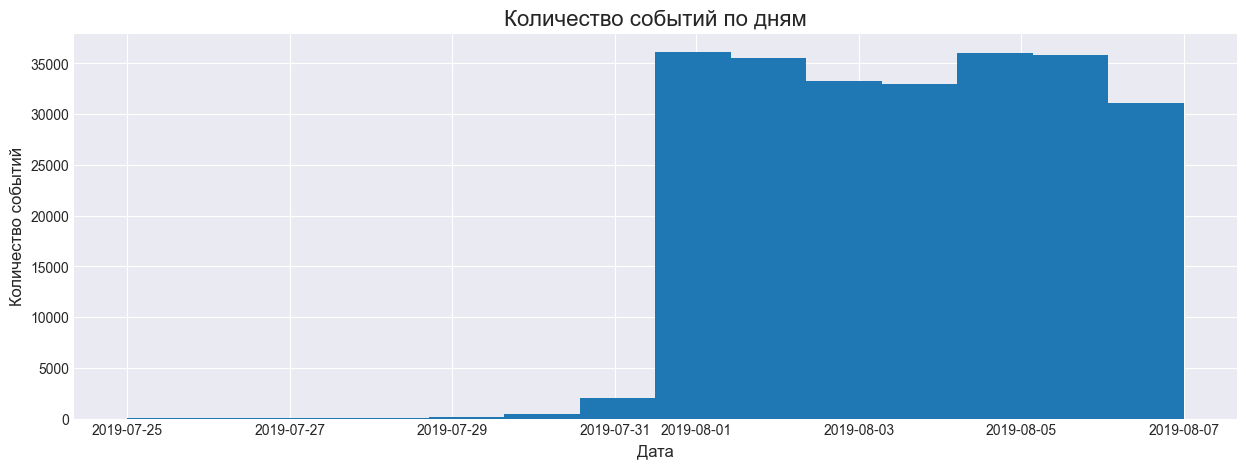

In [22]:
plt.figure(figsize=(15, 5))
logs.date.hist(bins=14)
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Количество событий', fontsize = 12)
plt.title('Количество событий по дням', fontsize=16);

Данные у нас с 25 июля по 7 августа, но основной массив информации, судя по графику, с 1 по 7 августа.  

Также с 1 по 8 августа количество событий примерно равное, в пределах 30-35 тысяч. В период 25-31 июля событий существенно меньше.  

Для более объективного анализа есть смысл отбросить данные за июль, и оставить только события августа. 

In [23]:
logs_filtered = logs[logs['date']>'2019-07-31']

In [24]:
logs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   user_id          240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   group            240887 non-null  int64         
 4   date_time        240887 non-null  datetime64[ns]
 5   date             240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


In [25]:
# доля потерянных строк в таблице

'{:.1%}'.format(len(logs_filtered.date)/len(logs.date) - 1)

'-1.2%'

In [26]:
# количество удаленных строк

len(logs.date) - len(logs_filtered.date)

2826

In [27]:
# доля потерянных уникальных пользователей

'{:.1%}'.format(logs_filtered.user_id.nunique()/logs.user_id.nunique() - 1)

'-0.2%'

In [28]:
# количество удаленных пользователей

logs.user_id.nunique() - logs_filtered.user_id.nunique()

17

Отфильтровав даты с наименьшим количеством событий мы потеряли 1,2% всех данных, 2826 строк, и только 0,2% пользователей, 17 человек. 

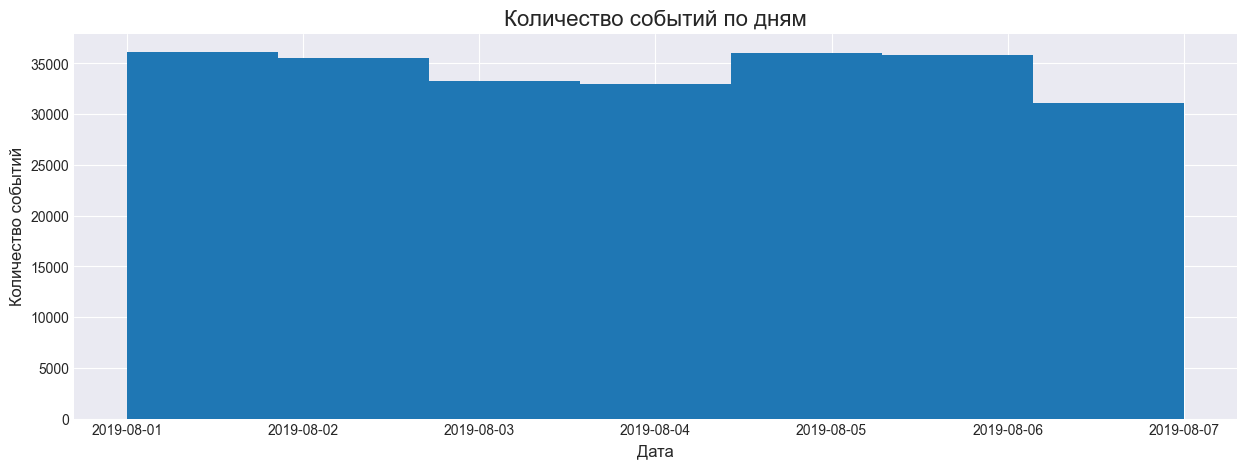

In [29]:
plt.figure(figsize=(15,5))
logs_filtered.date.hist(bins=7)
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Количество событий', fontsize = 12)
plt.title('Количество событий по дням', fontsize=16);

Теперь распределение событий по датам ровное. 

Для дальнейшего анализа убедимся, что у нас есть пользователи всех тестируемых групп. Проверим как их наличие, так и распределение по количеству пользователей. 

In [30]:
logs_filtered.group.unique()

array([246, 247, 248], dtype=int64)

Пользователи всех групп есть в данных. 

In [31]:
# делаем выборки пар (id клиента - группа)

users_a = logs_filtered[logs_filtered['group']==246][['user_id', 'group']].drop_duplicates()

In [32]:
users_a2 = logs_filtered[logs_filtered['group']==247][['user_id', 'group']].drop_duplicates()

In [33]:
users_b = logs_filtered[logs_filtered['group']==248][['user_id', 'group']].drop_duplicates()

In [34]:
print(users_a.count())
print('')
print(users_a2.count())
print('')
users_b.count()

user_id    2484
group      2484
dtype: int64

user_id    2513
group      2513
dtype: int64



user_id    2537
group      2537
dtype: int64

Количетво пользователей по группам также распределено равномерно. 

# Воронка событий

Ознакомимся с самими событиями, которые присутствуют в нашей таблице. 

In [35]:
# список событий и частота их появления

logs_filtered.event_name.value_counts(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Имеем _Обучение_, _Показ начальной страницы_, _Показ страницы с предложением_, _Показ корзины_, _Страница об успешно совершенном платеже_.  

Наиболее часто происходит показ главного экрана, что логично, так как это случается как минимум при каждом заходе в приложение.  

Самое непопулярное событие &#8212; обучение. Это можно связать с тем, что само по себе обучение &#8212; разовая процедура, и часть пользователей может его пропускать. 

Также проверим, как много пользователей совершают то или иное событие.  

Сгруппируем наши данные по событиям и посчитаем:  
- число пользователей, которые их вызывали;
- долю этих пользователей от всех.

In [36]:
events_by_users = (logs.groupby('event_name', as_index=False)
  .agg(users_count = ('user_id','nunique'))
  .sort_values('users_count')
  .reset_index(drop=True)
)

In [37]:
events_by_users['users_ratio'] = (
    events_by_users['users_count']/logs_filtered['user_id'].nunique()
    ).round(2)

In [38]:
events_by_users

,event_name,users_count,users_ratio
0,Tutorial,847,0.11
1,PaymentScreenSuccessful,3547,0.47
2,CartScreenAppear,3749,0.50
3,OffersScreenAppear,4613,0.61
4,MainScreenAppear,7439,0.99


Видим, что на главный экран смотрят почти 99% пользователей.  

Цепочка событий скорее всего выстраивается так:  
MainScreenAppear > OffersScreenAppear > CartScreenAppear > PaymentScreenSuccessful

Обучение, чисто логически, идет самым первым шагом при первом запуске приложения, после чего больше не появляется.  

Рассматривать его в рамках этой воронки не будем. Из таблицы тоже уберем. 

In [39]:
events_by_users = events_by_users.drop([0], axis=0)

Проверим, какая доля пользователей переходят с одного события к другому, и на каких этапах у нас наибольший отток. 

In [40]:
events_by_users['churn_rate'] = (events_by_users['users_count']/events_by_users['users_count'].shift(-1)).round(2)

In [41]:
events_by_users

,event_name,users_count,users_ratio,churn_rate
1,PaymentScreenSuccessful,3547,0.47,0.95
2,CartScreenAppear,3749,0.50,0.81
3,OffersScreenAppear,4613,0.61,0.62
4,MainScreenAppear,7439,0.99,NaN


__Визуализируем воронку событий__

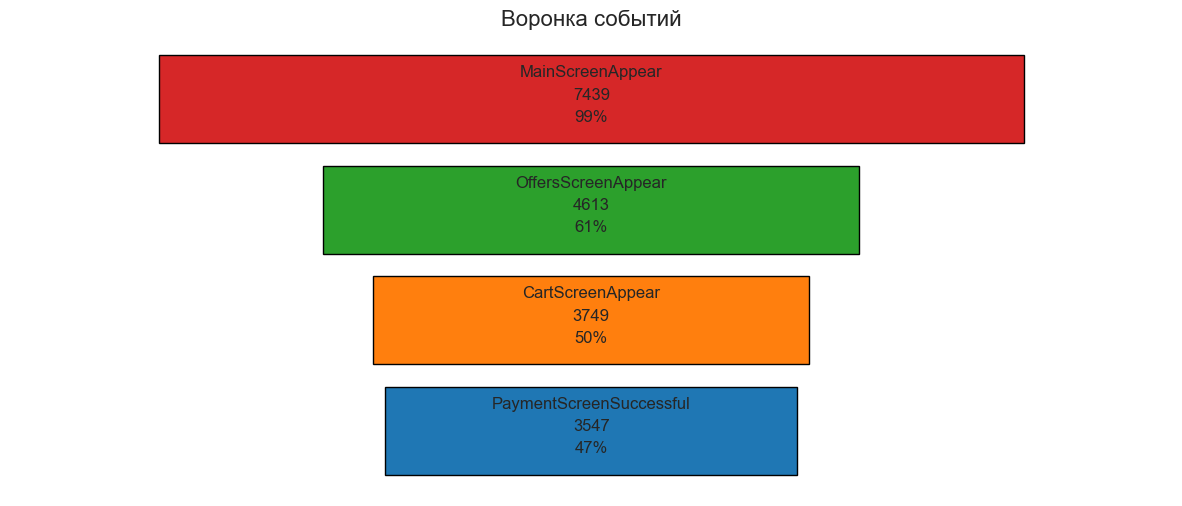

In [42]:
# сохраним в список название событий
y = events_by_users['event_name'].to_list()

# индексы событий
у_idx = list(events_by_users['event_name'].index)

# количество посетителей
x = events_by_users['users_count'].to_list()

# доля посетителей от всех
ratio = (events_by_users['users_ratio'].apply('{:.0%}'.format)).to_list()

# зададим ограничения по значениям оси Х
x_max = 10000
x_min = 0

plt.figure(figsize=(15,6))

for idx, val in enumerate(x):
    
    left = (x_max - val)/2
    plt.barh(y[idx], x[idx], left = left, height=0.8, edgecolor='black')
    
    plt.text(5000, у_idx[idx]-0.8, y[idx], ha='center', fontsize=12)
    plt.text(5000, у_idx[idx]-1, x[idx], ha='center', fontsize=12)
    plt.text(5000, у_idx[idx]-1.2, ratio[idx], ha='center', fontsize=12)

plt.axis('off')
plt.title('Воронка событий', fontsize=16)
plt.xlim(x_min, x_max)
plt.show()

Становится очевидно, что наибольший оток происходит на этапе с первого по второе событие, то есть с главного экрана до показа продукта. На этом шаге отваливается 38% пользователей.  

Дальнейшие шаги уже не имеют таких потерь. Лучшая доходимость у тех пользователей, которые заходят в корзину. 

И чтобы картина стала еще более наглядной, посчитаем, какая доля пользователей проходят от первого по последнего, ключевого события. 

In [43]:
'{:.1%}'.format(events_by_users['users_count'][1]/events_by_users['users_count'][4])

'47.7%'

47.7% пользователей доходят до покупки. 

## Промежуточный вывод

Проанализировали воронку событий.  

Наибольший отток пользователей в воронке происходит на первом шаге, то есть при переходе с главного экрана к просмотру товара. До второго шага доходят только 62% прользователей.  

Полный путь проходят 47.7% пользователей. 

# Анализ результатов эксперимента

## Проверка данных

Перейдем к проверке результатов A/A/B-теста.  

Первым делом вспомним, какое количество пользоватлей по группам.  

Также проверим, нет ли таких клиентов, которые попали в несколько групп одновременно. 

In [44]:
users_a.count()

user_id    2484
group      2484
dtype: int64

In [45]:
users_a2.count()

user_id    2513
group      2513
dtype: int64

In [46]:
users_b.count()

user_id    2537
group      2537
dtype: int64

Выборки по количеству пользователей почти идентичные


Проверим, как соотносятся наши контрольные группы по количеству пользователей. Если различие не более 1.5 процентов, считаем, что разделение произошло корректное. 

In [47]:
(users_a.count()/users_a2.count())-1

user_id   -0.01154
group     -0.01154
dtype: float64

Разница между группами составляет 1.2%, разделение корректное. 

In [48]:
# проверяем, не попали ли пользователи в несколько групп одновременно

users_groups = logs_filtered[['user_id', 'group']].drop_duplicates()

In [49]:
users_groups.user_id.duplicated().sum()

0

Группы разделены четко, "шпионов" нет. 

## Распределение пользователей по событиям.  Контрольные группы.

Проверим, как происходит распределение пользователей по событиям в разрезе каждой группы.  

Также проверим, являются ли различие между группами статистически значимым. 

Построим сводную таблицу, как в более ранних шагах, только в этот раз добавим фильтрацию пользователей по группам. 

In [50]:
events_users_a = (
    logs_filtered[logs_filtered['group']==246]
    .groupby('event_name', as_index=False)
    .agg(users_count=('user_id', 'nunique'))
    .sort_values('users_count', ascending=False)
    .reset_index(drop=True)
)

In [51]:
events_users_a2 = (
    logs_filtered[logs_filtered['group']==247]
    .groupby('event_name', as_index=False)
    .agg(users_count=('user_id', 'nunique'))
    .sort_values('users_count', ascending=False)
    .reset_index(drop=True)
)

In [52]:
# Убираем обучение

events_users_a = events_users_a.drop([4], axis=0)

In [53]:
# Убираем обучение

events_users_a2 = events_users_a2.drop([4], axis=0)

In [54]:
events_users_a

,event_name,users_count
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


In [55]:
events_users_a2

,event_name,users_count
0,MainScreenAppear,2476
1,OffersScreenAppear,1520
2,CartScreenAppear,1238
3,PaymentScreenSuccessful,1158


In [56]:
# добавляем долю пользователей, совершивших событие

events_users_a['user_ratio'] = events_users_a['users_count']/users_a['user_id'].count()
events_users_a['user_total'] = users_a['user_id'].count()

In [57]:
events_users_a

,event_name,users_count,user_ratio,user_total
0,MainScreenAppear,2450,0.986312,2484
1,OffersScreenAppear,1542,0.620773,2484
2,CartScreenAppear,1266,0.509662,2484
3,PaymentScreenSuccessful,1200,0.483092,2484


In [58]:
events_users_a2['user_ratio'] = events_users_a2['users_count']/users_a2['user_id'].count()
events_users_a2['user_total'] = users_a2['user_id'].count()

In [59]:
events_users_a2

,event_name,users_count,user_ratio,user_total
0,MainScreenAppear,2476,0.985277,2513
1,OffersScreenAppear,1520,0.604855,2513
2,CartScreenAppear,1238,0.492638,2513
3,PaymentScreenSuccessful,1158,0.460804,2513


Теперь посчитаем, как соотносится количество пользователей, совершивших событие, между контрольными группами. Являются ли отличия между ними статистически значимыми.  
Эта проверка покажет, было ли разделение контрольных групп коректным.  

Для проверки будем использовать z-тест для пропорций. 

**Ho**: контрольные группы одинаковые.  
**H1**: между контрольными группами есть различия. 

In [60]:
# напишем функцию для z-теста

def ztest (x, y, alpha):
    
    for i in range(len(x['users_count'])):

        
        successes = np.array([x['users_count'][i], y['users_count'][i]])
        trials = np.array([x['user_total'][0], y['user_total'][0]])

        p1 = successes[0]/trials[0]
        p2 = successes[1]/trials[1]

        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        difference = p1 - p2

        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        distr = st.norm(0, 1) 

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(x['event_name'][i], 'p-значение: ', '{:.3f}'.format(p_value))

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
        
        print ('')

In [61]:
# alpha = 0.05

ztest(events_users_a, events_users_a2, 0.05)

MainScreenAppear p-значение:  0.757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение:  0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение:  0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение:  0.115
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Тест показал, что по всем событиям различия не являются статистически значимыми, и поэтому можно считать контрольные группы одинаковыми. Разделение пользователей выполнено корректно. 

## Сравнение с тестируемой группой

Теперь проверим, есть ли изменения в тестируемой группе, относительно контрольных.  

Проведем такую же проверку. Сравним тестируему группу с обеими контрольными в отдельности, и с объединенными данными. 

Для начала соберем данные по группе Б в таблицу, как и по группам А. 

In [62]:
events_users_b = (
    logs_filtered[logs_filtered['group']==248]
    .groupby('event_name', as_index=False)
    .agg(users_count=('user_id', 'nunique'))
    .sort_values('users_count', ascending=False)
    .reset_index(drop=True)
)

In [63]:
events_users_b['user_ratio'] = events_users_b['users_count']/users_b['user_id'].count()
events_users_b['user_total'] = users_b['user_id'].count()

In [64]:
events_users_b = events_users_b.drop([4], axis=0)

In [65]:
events_users_b

,event_name,users_count,user_ratio,user_total
0,MainScreenAppear,2493,0.982657,2537
1,OffersScreenAppear,1531,0.603469,2537
2,CartScreenAppear,1230,0.484825,2537
3,PaymentScreenSuccessful,1181,0.465510,2537


Проведем z-тест группы Б с группой А, далее с группой А1, далее с объединенной таблицей по А и А1.

**Ho**: между группами А и Б нет отличий;  
**H1**: группы А и Б отличаются. 

In [66]:
ztest(events_users_a, events_users_b, 0.05)

MainScreenAppear p-значение:  0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение:  0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение:  0.078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение:  0.212
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [67]:
ztest(events_users_b, events_users_a2, 0.05)

MainScreenAppear p-значение:  0.459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение:  0.920
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение:  0.579
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение:  0.737
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [68]:
# объединили данные по контрольным группам

events_users_a_combined = (
    logs_filtered[logs_filtered['group'].isin([246, 247])]
    .groupby('event_name', as_index=False)
    .agg(users_count=('user_id', 'nunique'))
    .sort_values('users_count', ascending=False)
    .reset_index(drop=True)
)

In [69]:
events_users_a_combined['user_ratio'] = (
    events_users_a_combined['users_count']/
    logs_filtered[logs_filtered['group'].isin([246, 247])]['user_id'].nunique()
    )
events_users_a_combined['user_total'] =(
     logs_filtered[logs_filtered['group'].isin([246, 247])]['user_id'].nunique()
     )

In [70]:
# удаляем обучение

events_users_a_combined = events_users_a_combined.drop([4], axis=0)

In [71]:
events_users_a_combined

,event_name,users_count,user_ratio,user_total
0,MainScreenAppear,4926,0.985791,4997
1,OffersScreenAppear,3062,0.612768,4997
2,CartScreenAppear,2504,0.501101,4997
3,PaymentScreenSuccessful,2358,0.471883,4997


In [72]:
ztest(events_users_b, events_users_a_combined, 0.05)

MainScreenAppear p-значение:  0.294
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение:  0.434
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение:  0.182
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение:  0.600
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



По итогам этого теста статистически значимых различий между контрольными и тестируемой группами не выявлено.  

У нас нет оснований заявить, что они отличаются. 

## Обоснование выбранного уровня статистической значимости

При проведении теста мы выбрали уровень статистической значимости равный 5%, `alpha = 0.05`.  

С подобным уровнем значимости мы имеем вероятность получить ошибку первого рода каждый двадцатый раз. Планируемое (и по факту проведенное) количество сравнений &#8212; 16, по 4 на каждую из пар групп. Соответсвенно, выбрать уровень значимости более 5% мы не могли изначально.  

Однако, так как у нас не две, а три группы сравнения, поэтому вероятность ошибки первого рода возрастает.  

Вероятность получить ошибку первого рода при множественном сравнении равняется `1-(1-alpha)**n`, где `n` &#8212; количество сравнений. Посчитаем эту вероятность для нашего случая. 

In [73]:
# вероятность ошибки первого рода

1-(1-0.05)**16

0.5598733313482347

Видим, что в нашем случае вероятность получить ложнопозитивный результат выросла с 5 до 56%. В этом случае необходимо сделать поправку уровня значимости для множественных сравнений.  

Применим поправку Бонферрони, разделим `alpha` на количество тестов, 16. 

In [74]:
alpha = 0.05/16
alpha

0.003125

In [75]:
# вероятность ошибки первого рода для скорректированного alpha

1-(1-alpha)**16

0.048845042569365726

Получаем скорректированный `alpha` 0,3%. С ним вероятность ошибки первого рода становится близкой к 5%.   

Мы могли бы провести проверку заново, учитывая в ней новую `alpha`, однако по результатам проведенных тестов можно заключить, что в этом нет смысла. Полученные `p-value` слишком велики, и не приближаются к уровню статистической значимости. 

# Вывод

В ходе этого исследования работали с логами интернет-магазина продуктов. 

__Мы оценили воронку событий в мобильном приложении__. Выявили, что наибольший отток клиентов происходит на первом шаге, при переходе от главного экрана к информации о продукте. На этом этапе отваливается 38% пользователей.  

Общая доходимость от первого шага до покупки &#8212; 47.7%.  

В воронку событий не стали добавлять обучение. Очевидно, что по количеству пользователей, которые его прошли, это необязательный момент, и его можно пропустить.  

В самой воронке мы заметили, что главный экран просмотрели не все пользователи, а только 99% из них. Мое предположение, что оставшийся 1% &#8212; это клиенты, которые при первом использовании приложения увидели экран с обучением, и не стали дальше пользоваться приложением.

__Проанализировали результаты A/A/B-теста__.  

Пользователей делили на три группы: две контрольные и одна тестируемая, с измененным шрифтом в приложении.   

По результатам проверки можем сделать вывод, что группы А и Б не отличаются друг от друга на статистически значимую величину. Внесенные изменения не повлияли на поведение пользователей. 